<a href="https://colab.research.google.com/github/joelm67/Remote-Sensing-Python/blob/main/Copy_of_intermediate_gdal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More with GDAL

Now that we covered basic GDAL concepts including how to import the library, open a dataset, read metadata from a dataset, read data from a dataset into an array, use the array to do something (e.g. calculate NDVI), and write a new result to a new file (that was a lot!) we will now focus on more intermediate concepts with GDAL.

First, let's revisit `GetRasterBand(<index>).ReadAsArray()`. As you already know, `GetRasterBand(<index>)` method allows us to get the band object by passing the band index (again 1-based) to the Dataset as in `band = ds.GetRasterBand(1)`. In this case, the band variable is a Python object and only knows the pointer to the first band. As you can see the python object is not a data file but rather a pointer to the GDAL structured object.  To read the actual data contained in the band, we need to add the `ReadAsArray()` method that takes the GDAL object and reads its contents into a Numpy array.

In [ ]:
#!apt update
#!apt upgrade
#!apt install gdal-bin python-gdal python3-gdal
#import gdal
#import numpy as np
#import matplotlib.pyplot as plt

# grab the image data from the cloud using wget and copy to a local file called "q3.tif"
#!wget "https://storage.googleapis.com/alexi_daily/EnvSt956/S2_20190816_win.tif" -O s2.tif
# open the local file using gdal open into a variable called ds
#ds = gdal.Open("s2.tif", gdal.GA_ReadOnly)
# read band 1 from the dataset into a variable (object) called band
# note 1-based counting
# band1 = blue
# band2 = green
# band3 = red
# band4 = NIR
# band5 = SWIR1
# band6 = SWIR2
band = ds.GetRasterBand(1) # get band 1
print('this is a python object')
print(band)
band = ds.GetRasterBand(1).ReadAsArray() # get band 1
print('\n this is a python array containing remotely sensed data')
print(band)
print('\n the following are numpy methods now that we read the data into an numpy array')
ydim = band.shape[0] # grab ydim
xdim = band.shape[1] # grab xdim
print(ydim, xdim)

It turns out `ReadAsArray()` method offers additional options for reading data from the GDAL object.  One important option is about how much to read!  That is do you want to read the entire image into a 2D array or a subset of it. This is accomplished by passing additional parameters to the `ReadAsArray()` method as follows: `ReadAsArray(<xoff>, <yoff>, <xsize>, <ysize>)`, where:
- xoff or xOffset - how much to move in X direction before start reading
- yoff or YOffset - how much to move in Y direction before start reading
- xsize - how many pixels in X direction to read
- ysize - how many pixels in Y direction to read

For example, to read the upper-left pixel (single pixel):
`data = band.ReadAsArray(0, 0, 1, 1)`

To read 3 x 3 pixels starting at 45th column and 96th row:
`data = band.ReadAsArray(44, 95, 3, 3)`

In [ ]:
# read one pixel
data = ds.GetRasterBand(1).ReadAsArray(0, 0, 1, 1)
print(data)
print(data.shape)
print("\n")
# read 3 x 3 pixels
data = ds.GetRasterBand(1).ReadAsArray(44, 95, 3, 3)
print(data)
print(data.shape)

[[453]]
(1, 1)


[[523 523 538]
 [524 524 532]
 [542 542 542]]
(3, 3)


Note that even though we only read one pixel value, it is in a two-dimensional array.  This is because we read one pixel in each direction, the array is of size 1x1.

An alternative method of selective pixel reading is to first read the entire image into a numpy array, and use numpy indexing to find the same pixel(s).  The caveats are:
- you must have enough RAM (memory) to read the whole image
- in the numpy method, the X and Y are swapped (numpy arrays are row major)

(5000, 5000)

 print the upper left pixel
453

 print the 3 x 3 array starting at row 96 and column 44
[[523 523 538]
 [524 524 532]
 [542 542 542]]

 lets display a subset of the full image
(500, 700)


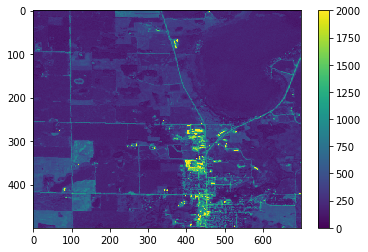

In [ ]:
# read the whole image
data = ds.GetRasterBand(1).ReadAsArray()
print(data.shape) 
print("\n print the upper left pixel")
print(data[0,0]) # print the upper left pixel

print("\n print the 3 x 3 array starting at row 96 and column 44")
# read 3 x 3 pixels
print(data[95:98,44:47])

print('\n lets display a subset of the full image')
subset = data[499:999,299:999]
print(subset.shape)
plt.imshow(subset, vmin = 0, vmax = 2000, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()


# Histograms and more

One of the most important image processing tools is the image image histogram. In my opinion, one can tell a lot about the image itself just by looking at its histogram.  To do this, we will use the `numpy.histogram()` method but first we must reshape the array so it has a single dimension (1D array).  This is becasue the `histogram()` method applied to 2D array would generate histograms at a single dimension at a time. We will use `np.reshape()` method to change the shape of the array from 2D to 1D.


In [ ]:
# band1 = blue
# band2 = green
# band3 = red
# band4 = NIR
# band5 = SWIR1
# band6 = SWIR2
b1 = ds.GetRasterBand(1).ReadAsArray() # get band 1
print('original 2D array: ',swir.shape)
ydim = b1.shape[0] # grab ydim
xdim = b1.shape[1] # grab xdim
b1 = np.reshape(b1,xdim*ydim) # reshape the array into 1D
print('reshaped 1D array: ',swir.shape)

original 2D array:  (25000000,)
reshaped 1D array:  (25000000,)


It turns out the histogram method has two option: a textual histogram where the bin values and their associated frequency are provided in new array [bin and count] and graphich version in which histogram parameters are passed to a plot option. In the xample below, we are using specific bin locations and passing them to the histogram method.  Other options to the `histogram()` method can be found [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html).  One way to specify bin location is to use the np.arange() method, which generates equally spaced values between min and max using the step parameter.  In the example below, we are generating equally spaced numbers between 0 and 10000 at 50 increments. In the second method, we are using the plt.hist() method, which is available to the plt object that came with the `matplotlib` library.

[   0   50  100  150  200  250  300  350  400  450  500  550  600  650
  700  750  800  850  900  950 1000 1050 1100 1150 1200 1250 1300 1350
 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 2050
 2100 2150 2200 2250 2300 2350 2400 2450 2500 2550 2600 2650 2700 2750
 2800 2850 2900 2950 3000 3050 3100 3150 3200 3250 3300 3350 3400 3450
 3500 3550 3600 3650 3700 3750 3800 3850 3900 3950 4000 4050 4100 4150
 4200 4250 4300 4350 4400 4450 4500 4550 4600 4650 4700 4750 4800 4850
 4900 4950 5000 5050 5100 5150 5200 5250 5300 5350 5400 5450 5500 5550
 5600 5650 5700 5750 5800 5850 5900 5950 6000 6050 6100 6150 6200 6250
 6300 6350 6400 6450 6500 6550 6600 6650 6700 6750 6800 6850 6900 6950
 7000 7050 7100 7150 7200 7250 7300 7350 7400 7450 7500 7550 7600 7650
 7700 7750 7800 7850 7900 7950 8000 8050 8100 8150 8200 8250 8300 8350
 8400 8450 8500 8550 8600 8650 8700 8750 8800 8850 8900 8950 9000 9050
 9100 9150 9200 9250 9300 9350 9400 9450 9500 9550 9600 9650 9700 9750
 9800 

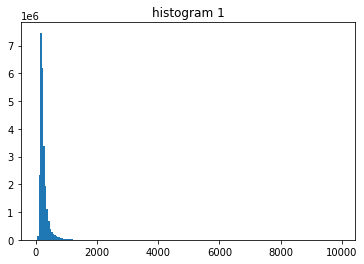

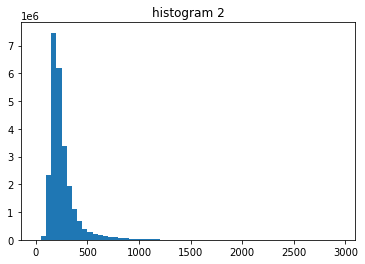

In [ ]:
# use the np.histogram() method to hold 
count,bins = np.histogram(b1, bins = np.arange(0,10000,50)) 
print(bins) 
print(count) 
plt.hist(b1, bins = np.arange(0,10000,50)) 
plt.title("histogram 1") 
plt.show()
plt.hist(b1, bins = np.arange(0,3000,50)) 
plt.title("histogram 2") 
plt.show()

Lets put this histogram to use! Here is a fun task.  We want to make a map that contains two labels: water (lake) and land.  How do we accopmplish this task?  It turns out it is pretty simple using image histograms.  Here are the steps:
- grab the band that has the most contrast between water and land
- plot the histogram of that band and find the pixel value that separates land from water
- use np.where() method to make a binary mask of land and water
- write the output as a classificaiton result in a new geotiff file.

Next, we'll read data using array option.

In [ ]:
b6 = ds.GetRasterBand(6).ReadAsArray() # band 6
ydim = b6.shape[0] # grab ydim
xdim = b6.shape[1] # grab xdim
swir = np.reshape(b6,xdim*ydim) 
count,bins = np.histogram(swir, bins = np.arange(0,3000,20)) 
print(bins) 
print(count) 
plt.hist(swir, bins = np.arange(0,3000,20)) 
plt.title("histogram 1") 
plt.show()

Now lets use the np.where() method